# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
# !pip install lightning wandb
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !curl -L -O https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
import os
import wandb
# !wandb login $WANDB_API_KEY
wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: Currently logged in as: pupipat-sk (pupipatsk). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/pupipatsingkhorn/.netrc


True

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [4]:
# !wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
# !curl -L -O https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

In [5]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1 #+1 for PADDING
output_vocab_size = len(output_chars)+2 #+2 for special end of sentence token, PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
print('There are %d lines and %d unique characters in your output data.' % (len(name_en), output_vocab_size))

maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max output length
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

There are 10887 lines and 65 unique characters in your input data.
There are 10887 lines and 24 unique characters in your output data.
Max input length: 20
Max output length: 19


In [8]:
# TODO:
# input(TH), special tokens: <PAD>
sorted_chars= sorted(input_chars)
sorted_chars.insert(0,"<PAD>")

# output(EN), special tokens: <PAD>, </s>
sorted_output_chars = sorted(output_chars)
sorted_output_chars.insert(0,"<PAD>")
sorted_output_chars.insert(1,"</s>")

def create_tokenizer(sorted_chars: list[str]):
    """
    Create a character-level tokenizer with mappings and encoding/decoding functions.

    Args:
        sorted_chars (list of str): Sorted list of unique characters.

    Returns:
        - 'chr_to_int_mapping': Character-to-integer mapping.
        - 'int_to_chr_mapping': Integer-to-character mapping.
        - 'encode': Function to encode a string into a list of integers.
        - 'decode': Function to decode a list of integers into a string.
    """
    chr_to_int_mapping = {ch: i for i, ch in enumerate(sorted_chars)} # chr_to_int_mapping[char] = int
    int_to_chr_mapping = {i: ch for i, ch in enumerate(sorted_chars)} # int_to_chr_mapping[int] = char
    encode = lambda s: [chr_to_int_mapping[c] for c in s] # encoder: take a string, output a list of integers
    decode = lambda l: ''.join([int_to_chr_mapping[i] for i in l]) # decoder: take a list of integers, output a string
    return chr_to_int_mapping, int_to_chr_mapping, encode, decode

input_stoi, input_itos, input_encode, input_decode = create_tokenizer(sorted_chars)
output_stoi, output_itos, output_encode, output_decode = create_tokenizer(sorted_output_chars)

# ex.
print(input_encode(name_th[0]))
print(input_decode(input_encode(name_th[0])))

[58, 2, 34, 39, 49, 40, 64]
ไกรสีห์


In [9]:
# TODO:
from typing import Callable, List

def preprocess_name_to_tensor(
    name_data: List[str], encode_fn: Callable[[List[str]], List[int]]
) -> torch.Tensor:
    """
    Convert a list of names into a tensor of encoded integers.

    Args:
        name_data (List[str]): List of names (strings) to be encoded.
        encode_fn (Callable[[List[str]], List[int]]): Encoding function to convert characters to integers.

    Returns:
        torch.Tensor: Tensor of encoded names. Padded if `pad=True`.
    """
    lst = []
    for name_str in name_data:
        name_lst = [c for c in name_str]
        lst.append(torch.tensor(encode_fn(name_lst)))  # Encode and convert to tensor

    # Pad sequences to ensure uniform length
    return nn.utils.rnn.pad_sequence(lst, batch_first=True, padding_value=0)

X = preprocess_name_to_tensor(name_th, input_encode)
Y = preprocess_name_to_tensor(name_en, output_encode)

# ex.
print(X.shape, X)
print(Y.shape, Y)

torch.Size([10887, 20]) tensor([[58,  2, 34,  ...,  0,  0,  0],
        [29, 45,  9,  ...,  0,  0,  0],
        [23, 49, 34,  ...,  0,  0,  0],
        ...,
        [ 2, 32, 35,  ...,  0,  0,  0],
        [31, 36, 45,  ...,  0,  0,  0],
        [29, 45, 17,  ...,  0,  0,  0]])
torch.Size([10887, 19]) tensor([[12, 18,  3,  ...,  0,  0,  0],
        [17, 10,  3,  ...,  0,  0,  0],
        [20, 10, 11,  ...,  0,  0,  0],
        ...,
        [12,  3, 14,  ...,  0,  0,  0],
        [17, 10,  3,  ...,  0,  0,  0],
        [17, 10,  3,  ...,  0,  0,  0]])


In [10]:
from torch.utils.data import Dataset, DataLoader


# TODO:
class NameDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.long()
        self.y = y.long()

    def __getitem__(self, idx):
        return {"x": self.X[idx], "y": self.y[idx]}

    def __len__(self):
        return len(self.X)


# TODO:
class NameDataModule(L.LightningDataModule):
    def __init__(self, train_data, y, batch_size, num_workers=0):
        super().__init__()
        self.train_data = train_data
        self.y = y
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: str):
        pass

    def collate_fn(self, batch, num_classes=len(input_stoi)):
        one_hot_x = torch.stack(
            [F.one_hot(b["x"], num_classes=num_classes) for b in batch]
        )
        return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

    def train_dataloader(self, shuffle=True):
        train_dataset = NameDataset(self.train_data, self.y)
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers,
        )
        return train_loader


# Initialize the DataModule
batch_size = 16
data_module = NameDataModule(X, Y, batch_size=batch_size, num_workers=0)
# ex.
for batch in data_module.train_dataloader():
    print(batch["x"].shape, batch["y"].shape)
    print("(batch size, max sequence length, num classes)")
    break

torch.Size([16, 20, 65]) torch.Size([16, 19])
(batch size, max sequence length, num classes)


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [11]:
# TODO:
def one_step_attention(h, s_prev, fc_1, fc_2):
    """
    Args:
        h (torch.Tensor): Encoder outputs of shape (batch, seq_len, hidden_dim_enc).
        s_prev (torch.Tensor): Previous decoder hidden state of shape (batch, hidden_dim_dec).
    """
    # Split into Key-Value
    key, value = torch.split(h, h.size(-1)//2, dim=-1)
    # key: (batch, seq_len, key_dim=hidden_dim_enc/2), value: (batch, seq_len, value_dim=hidden_dim_enc/2)

    # Do concat with s_prev.
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful
    s_prev = s_prev.unsqueeze(1) # (batch, 1, hidden_dim_dec)
    s_prev = s_prev.repeat(1, key.size(1), 1) # (batch, seq_len, hidden_dim_dec)
    concat = torch.cat([key, s_prev], dim=-1) # (batch, seq_len, key_dim(=hidden_dim_enc/2) + hidden_dim_dec)

    # Attention function:
    # use layer(s) from your model to calculate attention_score and then softmax
    # fc_1: (batch, seq_len, key_dim + hidden_dim_dec) -> (batch, seq_len, attention_hidden_dim=hidden_dim_enc)
    # fc_2: (batch, seq_len, attention_hidden_dim=hidden_dim_enc) -> (batch, seq_len, 1)
    attention_score = F.relu(fc_2(F.tanh(fc_1(concat)))) # (batch, seq_len, 1)
    attention_score = F.softmax(attention_score, dim=1) # (batch, seq_len, 1)

    # calculate a context vector
    context = torch.mul(attention_score, value) # (batch, seq_len, value_dim=hidden_dim_enc/2)
    context = torch.sum(context, dim=1) # (batch, value_dim=hidden_dim_enc/2)
    return context, attention_score

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [12]:
class AttentionModel(L.LightningModule):
    def __init__(
        self,
        learning_rate=0.01,
        criterion=nn.CrossEntropyLoss(),
        input_vocab: dict = input_stoi,
        output_vocab: dict = output_stoi,
    ):
        super().__init__()
        # TODO:
        self.n_h = 32  # hidden dimensions for encoder
        self.n_s = 64  # hidden dimensions for decoder
        self.learning_rate = learning_rate
        self.criterion = criterion
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab

        # Encoder: can be any RNN of your choice -> Bidirectional LSTM
        # nn.LSTM return: output, (h_n, c_n)
        # BiLSTM-Output: h (batch_size, seq_len, 2*n_h), _ (h_n, c_n)
        self.encoder = nn.LSTM(
            len(self.input_vocab), self.n_h, batch_first=True, bidirectional=True
        )

        # Decoder: has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(input_size=self.n_h, hidden_size=self.n_s)

        # Attention:
        attention_input_dim = self.n_h + self.n_s  # 96 =32(2dir*32/2)+64=96 # key_dim(=hidden_dim_enc/2) + hidden_dim_dec
        attention_hidden_dim = self.n_h  # 32
        self.attention_fc_1 = nn.Linear(attention_input_dim, attention_hidden_dim) # 96 -> 32
        self.attention_fc_2 = nn.Linear(attention_hidden_dim, 1)  # 32 -> 1

        # Output layer:
        self.output_layer = nn.Linear(
            in_features=self.n_s, out_features=len(self.output_vocab)
        )

    def forward(self, src, return_attention=False, max_output_length=maxlen_out):
        # TODO:
        """
        Args:
            src: Input sequence (batch_size, seq_len).
            return_attention: use only when you want to get the attention scores for visualizing
        """
        # pass the input to the encoder
        h, _ = self.encoder(src)  # h: (batch_size, seq_len, 2 * n_h)

        # Initialize the LSTM states:
        # We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        # these states will get updated while we are decoding
        batch_size = src.shape[0]
        decoder_s = torch.randn(batch_size, self.n_s).to(
            self.decoder_lstm_cell.weight_ih.device
        )
        decoder_c = torch.randn(batch_size, self.n_s).to(
            self.decoder_lstm_cell.weight_ih.device
        )

        # Initialize prediction tensor
        prediction = torch.zeros(
            (batch_size, max_output_length, len(self.output_vocab))
        ).to(self.decoder_lstm_cell.weight_ih.device)

        # Iterate until max_output_length (Decoding)
        attention_scores = []  # to store the score for each step
        for t in range(max_output_length):
            # Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(
                h, decoder_s, self.attention_fc_1, self.attention_fc_2
            )
            attention_scores.append(attention_score)
            # Feed the context vector to the decoder.
            decoder_input = context
            decoder_s, decoder_c = self.decoder_lstm_cell(
                decoder_input, (decoder_s, decoder_c)
            )
            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)  # (batch_size, len(self.output_vocab))
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch["x"]
        target = batch["y"]
        prediction, _ = self(src)
        prediction = prediction.reshape(-1, len(self.output_vocab))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch["x"]
        with torch.no_grad():
            prediction, attention_scores = self(src, return_attention=True)
            prediction = F.softmax(prediction, dim=-1)
            prediction = torch.argmax(prediction, dim=-1)
            for pred in prediction:
                # TODO:
                # print("".join(self.output_vocab.lookup_tokens(pred.cpu().numpy())))
                print("".join(output_decode(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [13]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger

# Initialize
wandb_logger = WandbLogger(project="hw3-1-attention")
EPOCHS = 100
trainer = L.Trainer(max_epochs=EPOCHS, logger=wandb_logger)
model = AttentionModel(
    learning_rate=0.01,
    criterion=nn.CrossEntropyLoss(),
    input_vocab=input_stoi,
    output_vocab=output_stoi,
)
batch_size = 16
data_module = NameDataModule(X, Y, batch_size=batch_size, num_workers=0)

# Training...
# trainer.fit(model, data_module)
model = torch.load("attention-model.pth")

# Save model
torch.save(model, "attention-model.pth")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/var/folders/m6/fz_qjnl51s70hy69d_st2z240000gn/T/ipykernel_49550/596362770.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [14]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ']
EXAMPLES.insert(0, "ภูภิพัทธ์")
predict_data = preprocess_name_to_tensor(EXAMPLES, input_encode)


def collate_fn(batch, num_classes=len(input_stoi)):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=num_classes) for b in batch])
    return {"x": one_hot_x.float()}


predict_dataset = NameDataset(
    predict_data, torch.tensor([torch.tensor(0)] * len(predict_data))
)
predict_loader = DataLoader(
    predict_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0
)

model.eval()
output = trainer.predict(model, predict_loader)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/Users/pupipatsingkhorn/miniconda3/envs/datascience/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

phuphiphat<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
prayuttha<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
somchai<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
thanathon<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
newin<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
suthep<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
prawit<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
chatchachattit<PAD><PAD><PAD><PAD><PAD>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    # Axes
    'axes.titlesize': 16,
    'axes.titlepad': 20,
    'axes.labelsize': 12,
    'axes.edgecolor': (0.1, 0.1, 0.1),
    'axes.labelcolor': (0.1, 0.1, 0.1),
    'axes.linewidth': 1,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.grid': True,

    # Grid
    'grid.alpha': 0.7,
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,

    # Lines
    'lines.linewidth': 1.5,
    'lines.markeredgewidth': 0.0,

    # Scatter plot
    'scatter.marker': 'x',

    # Ticks
    'xtick.labelsize': 12,
    'xtick.color': (0.1, 0.1, 0.1),
    'xtick.direction': 'in',
    'ytick.labelsize': 12,
    'ytick.color': (0.1, 0.1, 0.1),
    'ytick.direction': 'in',

    # Figure output
    'figure.figsize': (10, 6),
    'figure.dpi': 200,
    'savefig.dpi': 200,

    # Text
    'text.color': (0.2, 0.2, 0.2),

    # Font
    "font.family": ["serif",
                    "Tahoma"] # TH Font
})

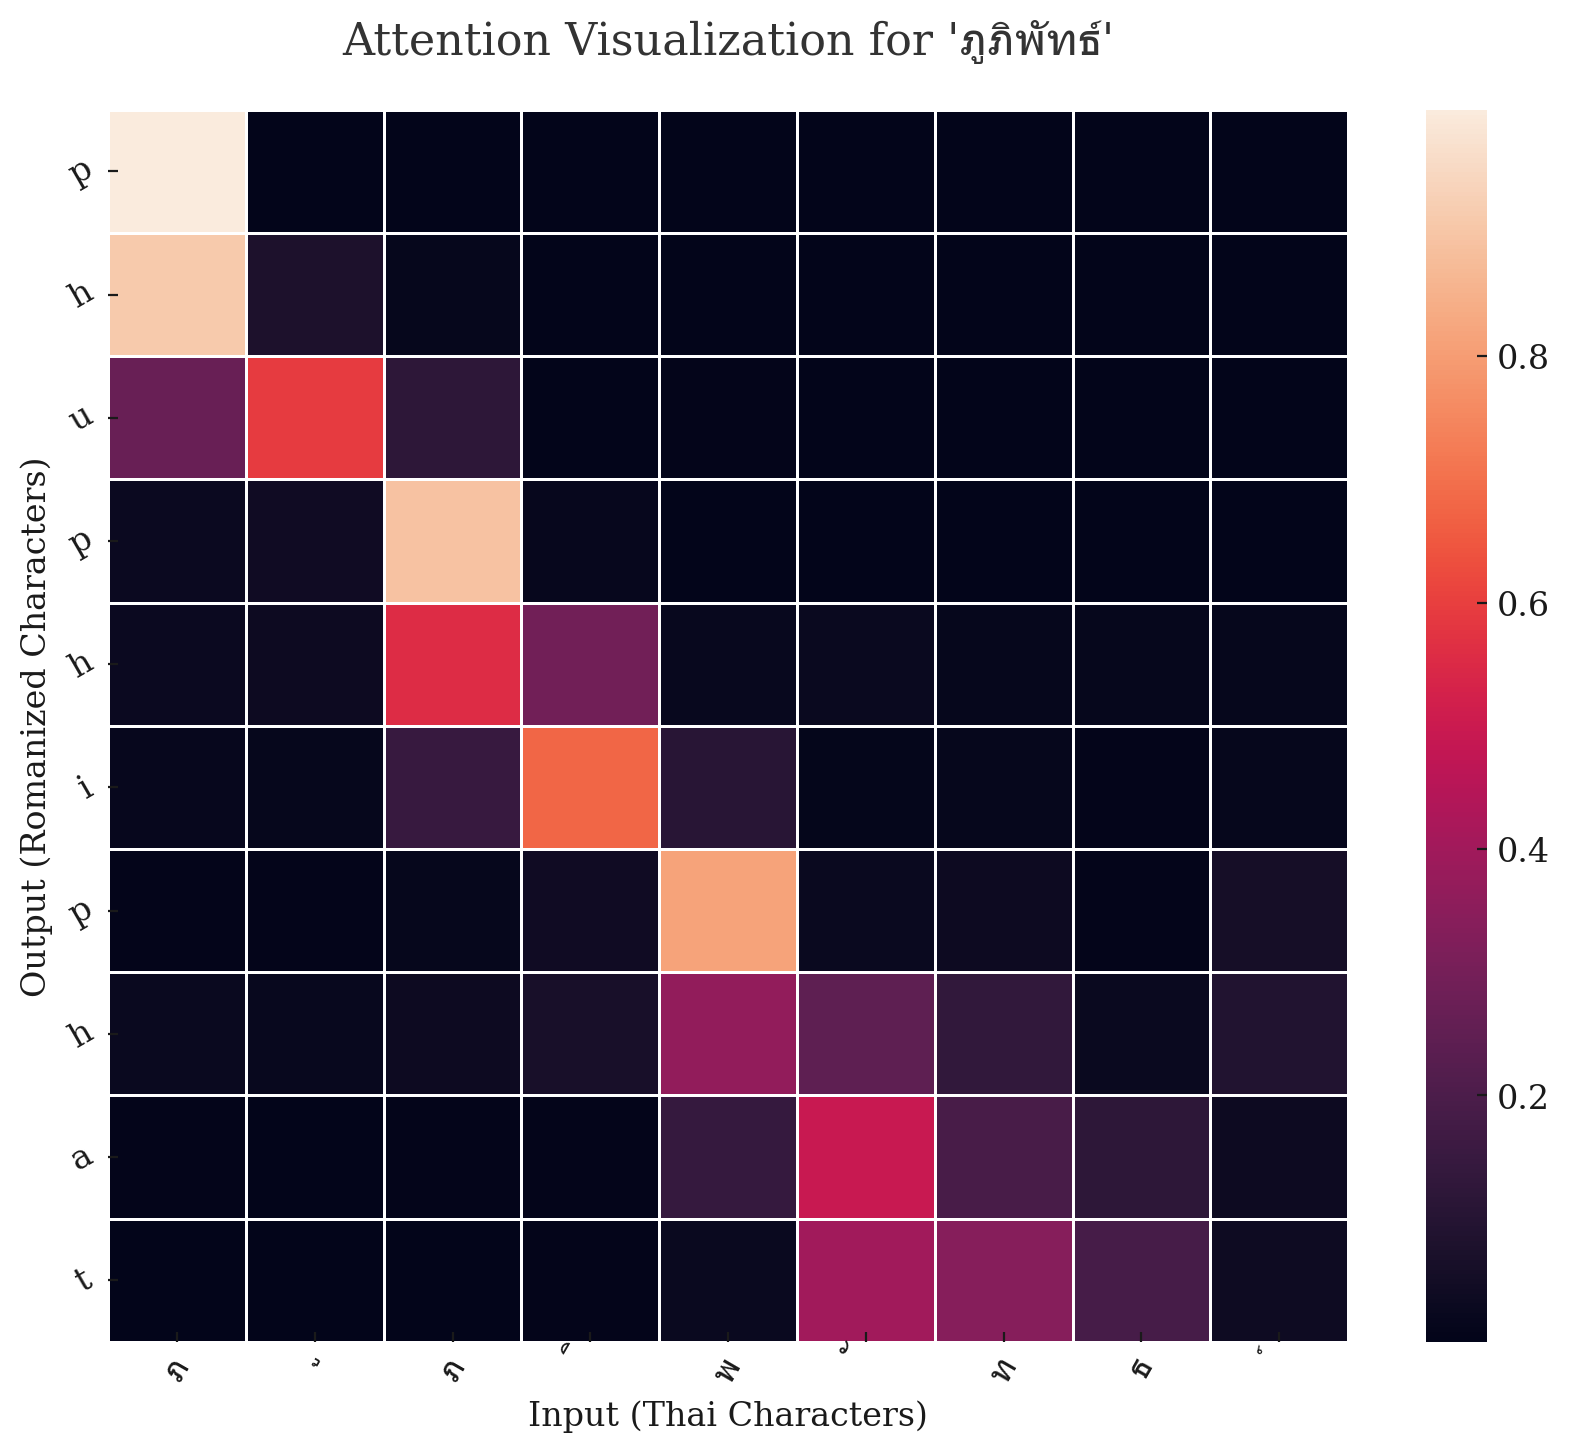

In [16]:
import seaborn as sns

# TODO:
prediction, attention_scores = zip(*output)

# Extract predictions and attention scores for the first example
sample_pred = prediction[0]
sample_pred = [token for token in sample_pred.cpu().numpy().tolist()[0] if token != 0]  # Remove padding tokens
sample_attention_scores = attention_scores[0]

# Stack the attention scores into a single array
attn_viz = torch.stack(sample_attention_scores).squeeze().cpu().numpy()

# Crop attention matrix to match the lengths of the input and output
attn_viz = attn_viz[:len(sample_pred), :len(EXAMPLES[0])]

# Decode output tokens into text
output_text = [char for char in output_decode(sample_pred)]

# Prepare input labels
xlabels = [char for char in EXAMPLES[0]]

# Validate dimensions
assert attn_viz.shape[0] == len(output_text), "Row count mismatch: attn_viz and output_text"
assert attn_viz.shape[1] == len(xlabels), "Column count mismatch: attn_viz and xlabels"

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text, rotation=30)
ax.set_xticklabels(xlabels, rotation=60)
plt.title(f"Attention Visualization for '{EXAMPLES[0]}'")
plt.ylabel("Output (Romanized Characters)")
plt.xlabel("Input (Thai Characters)")
plt.grid(False)
plt.show()
